In [1]:
pip install pygeos

     |████████████████████████████████| 1.6MB 9.5MB/s 


In [2]:
pip install geopandas

     |████████████████████████████████| 972kB 8.2MB/s 
     |████████████████████████████████| 10.9MB 28.6MB/s 
     |████████████████████████████████| 14.8MB 206kB/s 


In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as st
import altair as alt

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import kde
from google.colab import drive

drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Mounted at /content/drive


In [4]:
properties = pd.read_csv("/content/drive/My Drive/opa_properties_public.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,10,18,41,52,59,66,67,68,70,72) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
properties = properties[['registry_number','parcel_number','lat','lng','zip_code','sale_price','sale_date','total_area','total_livable_area','zoning','category_code','category_code_description']]

properties['sale_date'] = pd.to_datetime(properties['sale_date'], format='%Y-%m-%d')
properties['sale_year'] = pd.DatetimeIndex(properties['sale_date']).year

properties = properties[['registry_number','parcel_number','lat','lng','zip_code','sale_price','sale_date','sale_year','total_area','total_livable_area','zoning','category_code','category_code_description']]

properties.head()

,registry_number,parcel_number,lat,lng,zip_code,sale_price,sale_date,sale_year,total_area,total_livable_area,zoning,category_code,category_code_description
0,009S170265,11003600,39.930995,-75.147115,191476119,1.0,1991-12-17,1991.0,432.00,828.0,RSA5,1,Single Family
1,009S170266,11003700,39.931001,-75.147163,191476119,45000.0,1997-04-09,1997.0,448.00,870.0,RSA5,1,Single Family
2,009S170268,11003805,39.931011,-75.147235,191476119,278000.0,2011-01-14,2011.0,869.12,2106.0,RSA5,1,Single Family
3,009S170376,11004110,39.931193,-75.148488,191476020,520000.0,2016-08-31,2016.0,909.00,2162.0,RSA5,1,Single Family
4,009S170293,11004200,39.931211,-75.148584,191476020,410000.0,2016-03-25,2016.0,1453.68,3000.0,RSA5,1,Single Family


In [6]:
properties = properties[properties['sale_price'] > 1000]
properties = properties[properties['sale_year'] > 1999]

properties.shape

(306638, 13)

In [7]:
properties.loc[properties['sale_year'] < 2010, 'crash_indicator'] = 'before'
properties.loc[properties['sale_year'] > 2009, 'crash_indicator'] = 'after'

properties.head()

,registry_number,parcel_number,lat,lng,zip_code,sale_price,sale_date,sale_year,total_area,total_livable_area,zoning,category_code,category_code_description,crash_indicator
2,009S170268,11003805,39.931011,-75.147235,191476119,278000.0,2011-01-14,2011.0,869.12,2106.0,RSA5,1,Single Family,after
3,009S170376,11004110,39.931193,-75.148488,191476020,520000.0,2016-08-31,2016.0,909.00,2162.0,RSA5,1,Single Family,after
4,009S170293,11004200,39.931211,-75.148584,191476020,410000.0,2016-03-25,2016.0,1453.68,3000.0,RSA5,1,Single Family,after
9,009S170275,11005100,39.931072,-75.148531,191476005,164000.0,2012-05-04,2012.0,430.08,768.0,RSA5,1,Single Family,after
10,009S170236,11005200,39.931089,-75.148610,191476005,410000.0,2016-03-25,2016.0,595.44,936.0,RSA5,1,Single Family,after


In [8]:
testing = properties[properties['category_code']==1]

testing['decile'] = pd.qcut(testing.sale_price, 100, labels=False)
testing = testing[(testing['decile'] < 95) & (testing['decile'] > 1)]

testing.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,registry_number,parcel_number,lat,lng,zip_code,sale_price,sale_date,sale_year,total_area,total_livable_area,zoning,category_code,category_code_description,crash_indicator,decile
2,009S170268,11003805,39.931011,-75.147235,191476119,278000.0,2011-01-14,2011.0,869.12,2106.0,RSA5,1,Single Family,after,82
3,009S170376,11004110,39.931193,-75.148488,191476020,520000.0,2016-08-31,2016.0,909.00,2162.0,RSA5,1,Single Family,after,94
4,009S170293,11004200,39.931211,-75.148584,191476020,410000.0,2016-03-25,2016.0,1453.68,3000.0,RSA5,1,Single Family,after,91
9,009S170275,11005100,39.931072,-75.148531,191476005,164000.0,2012-05-04,2012.0,430.08,768.0,RSA5,1,Single Family,after,62
10,009S170236,11005200,39.931089,-75.148610,191476005,410000.0,2016-03-25,2016.0,595.44,936.0,RSA5,1,Single Family,after,91


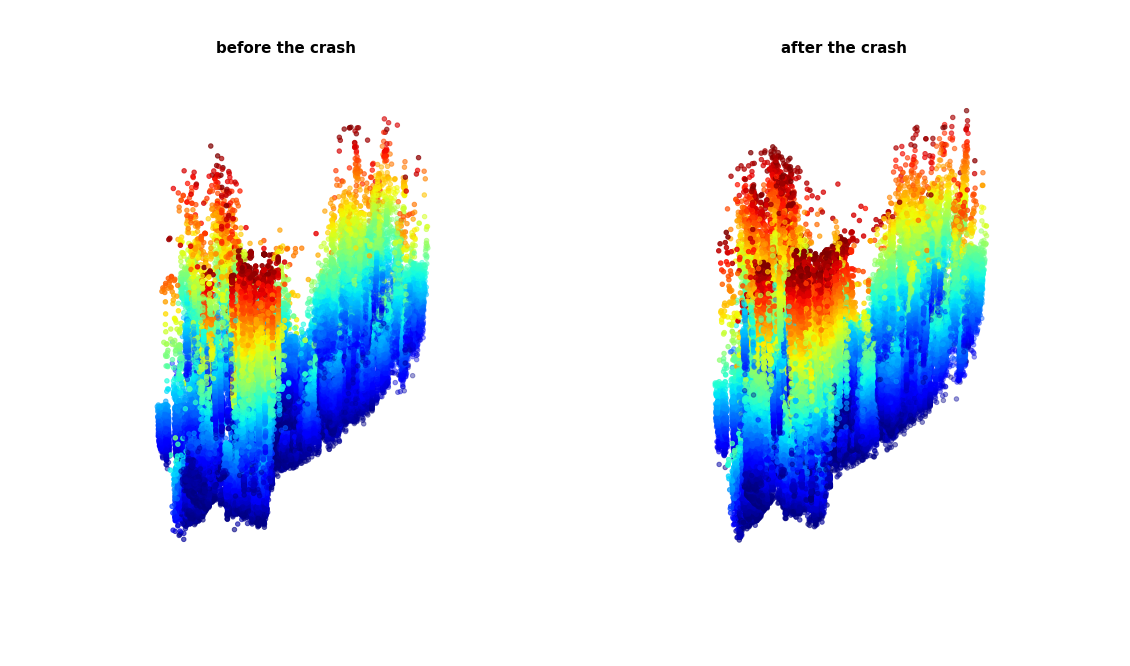

In [9]:
fig = plt.figure(figsize=(20,12))

ax = fig.add_subplot(1, 2, 1, projection='3d')

x = testing[testing['crash_indicator']=='before'].lng
y = testing[testing['crash_indicator']=='before'].lat
z = testing[testing['crash_indicator']=='before'].sale_price

past = ax.scatter3D(x, y, z, c=z, cmap='jet')
ax.view_init(45, 270)
ax.set_axis_off()
ax.set_title('before the crash', size=15, weight='bold')

ax = fig.add_subplot(1, 2, 2, projection='3d')

x = testing[testing['crash_indicator']=='after'].lng
y = testing[testing['crash_indicator']=='after'].lat
z = testing[testing['crash_indicator']=='after'].sale_price

pres = ax.scatter3D(x, y, z, c=z, cmap='jet')
ax.view_init(45, 270)
ax.set_axis_off()
ax.set_title('after the crash', size=15, weight='bold')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

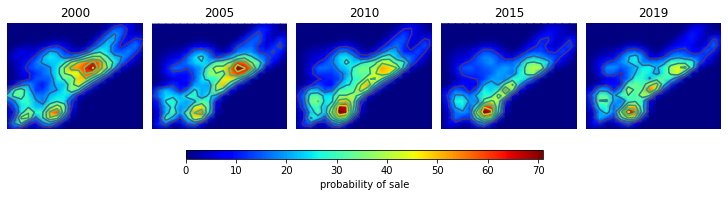

In [10]:
from scipy.stats import kde

fig, axs = plt.subplots(1, 5, figsize=(10,10), 
                        facecolor='w',
                        constrained_layout=True, 
                        sharex=True, sharey=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

nbins = 20
years = [2000, 2005, 2010, 2015, 2019]

for i in np.arange(0,5):
  
  year = years[i]

  x = testing[testing['sale_year']==year].lng
  y = testing[testing['sale_year']==year].lat

  axs[i].set_title(int(year))
  axs[i].axis('off')

  k = kde.gaussian_kde([x, y])
  x, y = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
  z = k(np.vstack([x.flatten(), y.flatten()]))

  axs[i].pcolormesh(x, y, z.reshape(x.shape), shading='gouraud', cmap='jet')
  axs[i].contour(x, y, z.reshape(x.shape) )

patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.5, label='probability of sale', orientation="horizontal")

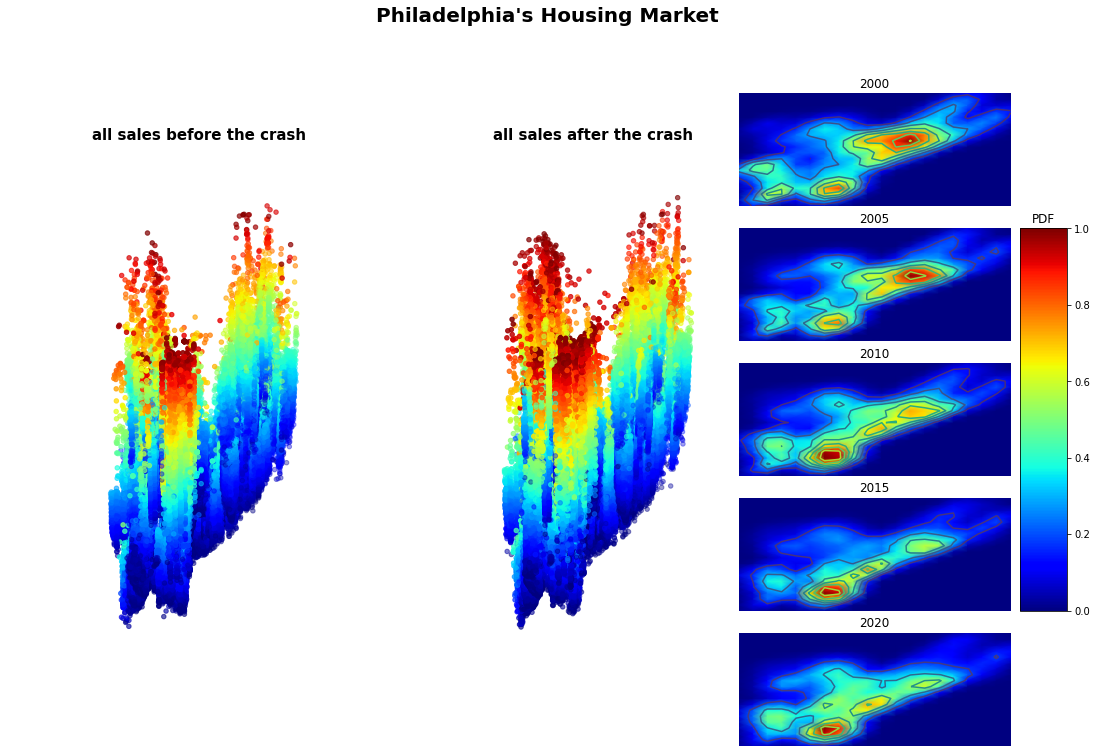

In [11]:
fig = plt.figure(figsize=(20,12))
gs = GridSpec(nrows=5, ncols=20)

ax = fig.add_subplot(gs[:, 0:7], projection='3d')

x = testing[testing['crash_indicator']=='before'].lng
y = testing[testing['crash_indicator']=='before'].lat
z = testing[testing['crash_indicator']=='before'].sale_price

past = ax.scatter3D(x, y, z, c=z, cmap='jet')
ax.view_init(45, 270)
ax.set_axis_off()
ax.set_title('all sales before the crash', size=15, weight='bold')

ax = fig.add_subplot(gs[:, 7:14], projection='3d')

x = testing[testing['crash_indicator']=='after'].lng
y = testing[testing['crash_indicator']=='after'].lat
z = testing[testing['crash_indicator']=='after'].sale_price

pres = ax.scatter3D(x, y, z, c=z, cmap='jet')
ax.view_init(45, 270)
ax.set_axis_off()
ax.set_title('all sales after the crash', size=15, weight='bold')

nbins = 20
years = [2000, 2005, 2010, 2015, 2020]

for i in np.arange(0,5):
  
  year = years[i]

  x = testing[testing['sale_year']==year].lng
  y = testing[testing['sale_year']==year].lat

  ax = fig.add_subplot(gs[i, 13:18])

  ax.set_title(int(year))
  ax.axis('off')

  k = kde.gaussian_kde([x, y])
  x, y = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
  z = k(np.vstack([x.flatten(), y.flatten()]))

  ax.pcolormesh(x, y, z.reshape(x.shape), shading='gouraud', cmap='jet')
  ax.contour(x, y, z.reshape(x.shape))

from matplotlib import cm

ax = fig.add_subplot(gs[1:4, 18])
ax.set_title("PDF")

cb = fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=ax, shrink=0.25, orientation="vertical")


fig.suptitle('Philadelphia\'s Housing Market', size=20, weight='bold')
plt.show()

In [12]:
x = testing[testing['sale_year']==2000].lng
y = testing[testing['sale_year']==2000].lat

deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10

xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

print(xmin, xmax, ymin, ymax)

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])

values = np.vstack([x, y])
kernel = st.gaussian_kde(values)

f = np.reshape(kernel(positions).T, xx.shape)

-75.3057691424011 -74.92921173071589 39.86878644344096 40.160023483505846


Text(0.5, 0.92, 'Distribution of Sales')

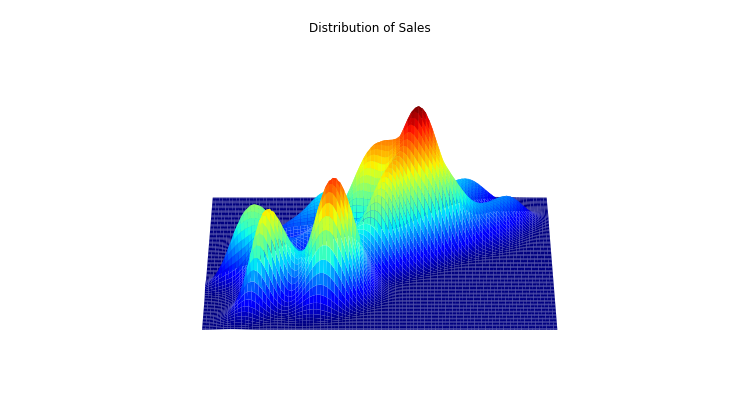

In [13]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='jet', edgecolor='none')
ax.set_axis_off()
ax.view_init(45, 270)

ax.set_title('Distribution of Sales')

In [14]:
properties['date'] = properties['sale_date'].dt.strftime('%Y-%m')
stream = properties.groupby(['category_code','date']).sale_price.agg(['sum', 'count']).reset_index()

In [15]:
stream1 = alt.Chart(stream).mark_area().encode(
    alt.X('yearmonth(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0)
    ),
    alt.Y('sum:Q', stack='center', axis=None),
    alt.Color('category_code:N',
        scale=alt.Scale(scheme='category20b')
    )
).properties(
    title='Aggregate value'
).interactive()

stream2 = alt.Chart(stream).mark_area().encode(
    alt.X('yearmonth(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0)
    ),
    alt.Y('count:Q', stack='center', axis=None),
    alt.Color('category_code:N',
        scale=alt.Scale(scheme='category20b')
    )
).properties(
    title='Sale count'
).interactive()

stream1.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

stream2.configure_title(
    fontSize=20,
    font='Gill Sans',
    anchor='start',
    color='gray'
)

stream1 | stream2

alt.HConcatChart(...)

In [16]:
hoods = gpd.read_file("https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson")
hoods = hoods.set_crs(epsg=4326)

In [32]:
shape = gpd.GeoDataFrame(properties, geometry=gpd.points_from_xy(properties.lng, properties.lat))
shape = shape.set_crs(epsg=4326)

joined = gpd.sjoin(shape, hoods)

In [33]:
joined['date'] = joined['sale_date'].dt.strftime('%Y-%m')
joined['neighborhood'] = joined['mapname']

stream = joined.groupby(['neighborhood','date']).sale_price.agg(['sum', 'count']).reset_index()

In [38]:
stream['metric'] = stream['sum']
aggregates = stream.groupby('neighborhood').metric.sum()
aggregates = aggregates.rank()

aggregates = pd.DataFrame(aggregates)
aggregates = aggregates[aggregates['metric']<11].reset_index()

top = stream[stream['neighborhood'].isin(aggregates['neighborhood'])]
bot = stream[~stream['neighborhood'].isin(aggregates['neighborhood'])]

bot['neighborhood'] = "other"

joined.loc[joined['neighborhood'].isin(aggregates['neighborhood']), 'name'] = 'top'
joined.loc[~joined['neighborhood'].isin(aggregates['neighborhood']), 'name'] = 'other'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,registry_number,parcel_number,lat,lng,zip_code,sale_price,sale_date,sale_year,total_area,total_livable_area,zoning,category_code,category_code_description,crash_indicator,date,geometry,index_right,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at,neighborhood
2,009S170268,11003805,39.931011,-75.147235,191476119,278000.0,2011-01-14,2011.0,869.12,2106.0,RSA5,1,Single Family,after,2011-01,POINT (-75.14724 39.93101),20,other,Pennsport,Pennsport,11823.233108,6.492473e+06,155,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,Pennsport
3,009S170376,11004110,39.931193,-75.148488,191476020,520000.0,2016-08-31,2016.0,909.00,2162.0,RSA5,1,Single Family,after,2016-08,POINT (-75.14849 39.93119),20,other,Pennsport,Pennsport,11823.233108,6.492473e+06,155,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,Pennsport
4,009S170293,11004200,39.931211,-75.148584,191476020,410000.0,2016-03-25,2016.0,1453.68,3000.0,RSA5,1,Single Family,after,2016-03,POINT (-75.14858 39.93121),20,other,Pennsport,Pennsport,11823.233108,6.492473e+06,155,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,Pennsport
9,009S170275,11005100,39.931072,-75.148531,191476005,164000.0,2012-05-04,2012.0,430.08,768.0,RSA5,1,Single Family,after,2012-05,POINT (-75.14853 39.93107),20,other,Pennsport,Pennsport,11823.233108,6.492473e+06,155,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,Pennsport
10,009S170236,11005200,39.931089,-75.148610,191476005,410000.0,2016-03-25,2016.0,595.44,936.0,RSA5,1,Single Family,after,2016-03,POINT (-75.14861 39.93109),20,other,Pennsport,Pennsport,11823.233108,6.492473e+06,155,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,Pennsport


In [43]:
top = joined[joined['name']=='top'].groupby(['neighborhood','date']).sale_price.agg(['sum', 'count']).reset_index()
bot = joined[joined['name']=='other'].groupby(['name','date']).sale_price.agg(['sum', 'count']).reset_index()

In [51]:
bot['neighborhood'] = bot['name']
bot = bot.drop('name', axis=1)

bot.head()

,date,sum,count,neighborhood
0,2000-01,44623722.0,482,other
1,2000-02,34325862.0,441,other
2,2000-03,62979062.0,610,other
3,2000-04,85406661.0,608,other
4,2000-05,72075385.0,728,other


In [57]:
all = top

In [58]:
stream1 = alt.Chart(all).mark_area().encode(
    alt.X('yearmonth(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0)
    ),
    alt.Y('sum:Q', stack='center', axis=None),
    alt.Color('neighborhood:N',
        scale=alt.Scale(scheme='category20b')
    )
).properties(
    title='Aggregate value'
).interactive()

stream2 = alt.Chart(all).mark_area().encode(
    alt.X('yearmonth(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0)
    ),
    alt.Y('count:Q', stack='center', axis=None),
    alt.Color('neighborhood:N',
        scale=alt.Scale(scheme='category20b')
    )
).properties(
    title='Sale count'
).interactive()

stream1.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

stream2.configure_title(
    fontSize=20,
    font='Gill Sans',
    anchor='start',
    color='gray'
)

stream1 | stream2

alt.HConcatChart(...)